In [1]:
import pandas as pd

food_orders = pd.read_csv("food_orders_new_delhi.csv")
print(food_orders.head())

   Order ID Customer ID Restaurant ID  Order Date and Time  \
0         1       C8270         R2924  2024-02-01 01:11:52   
1         2       C1860         R2054  2024-02-02 22:11:04   
2         3       C6390         R2870  2024-01-31 05:54:35   
3         4       C6191         R2642  2024-01-16 22:52:49   
4         5       C6734         R2799  2024-01-29 01:19:30   

  Delivery Date and Time  Order Value  Delivery Fee    Payment Method  \
0    2024-02-01 02:39:52         1914             0       Credit Card   
1    2024-02-02 22:46:04          986            40    Digital Wallet   
2    2024-01-31 06:52:35          937            30  Cash on Delivery   
3    2024-01-16 23:38:49         1463            50  Cash on Delivery   
4    2024-01-29 02:48:30         1992            30  Cash on Delivery   

  Discounts and Offers  Commission Fee  Payment Processing Fee  \
0            5% on App             150                      47   
1                  10%             198                  

In [2]:
print(food_orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Order ID                1000 non-null   int64 
 1   Customer ID             1000 non-null   object
 2   Restaurant ID           1000 non-null   object
 3   Order Date and Time     1000 non-null   object
 4   Delivery Date and Time  1000 non-null   object
 5   Order Value             1000 non-null   int64 
 6   Delivery Fee            1000 non-null   int64 
 7   Payment Method          1000 non-null   object
 8   Discounts and Offers    815 non-null    object
 9   Commission Fee          1000 non-null   int64 
 10  Payment Processing Fee  1000 non-null   int64 
 11  Refunds/Chargebacks     1000 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 93.9+ KB
None


In [5]:
# First, let's create a function to extract numeric values from the 'Discounts and Offers' string
def extract_discount(discount_str):
    if isinstance(discount_str, str):
        if 'off' in discount_str:
            # Fixed amount off
            return float(discount_str.split(' ')[0])
        elif '%' in discount_str:
            # Percentage off
            return float(discount_str.split('%')[0])
        else:
            # No discount
            return 0.0
    else:
        # Return 0.0 if it's not a string (e.g., NaN or float)
        return 0.0

# Apply the function to create a new 'Discount Percentage' column
food_orders['Discount Percentage'] = food_orders['Discounts and Offers'].apply(lambda x: extract_discount(x))

# For percentage discounts, calculate the discount amount based on the order value
food_orders['Discount Amount'] = food_orders.apply(lambda x: (x['Order Value'] * x['Discount Percentage'] / 100)
                                                   if x['Discount Percentage'] > 1
                                                   else x['Discount Percentage'], axis=1)

# Adjust 'Discount Amount' for fixed discounts directly specified in the 'Discounts and Offers' column
food_orders['Discount Amount'] = food_orders.apply(lambda x: x['Discount Amount'] if x['Discount Percentage'] <= 1
                                                   else x['Order Value'] * x['Discount Percentage'] / 100, axis=1)

# Check the first few rows and column data types
print(food_orders[['Order Value', 'Discounts and Offers', 'Discount Percentage', 'Discount Amount']].head(), food_orders.dtypes)


   Order Value Discounts and Offers  Discount Percentage  Discount Amount
0         1914            5% on App                  5.0            95.70
1          986                  10%                 10.0            98.60
2          937         15% New User                 15.0           140.55
3         1463                  NaN                  0.0             0.00
4         1992         50 off Promo                 50.0           996.00 Order ID                           int64
Customer ID                       object
Restaurant ID                     object
Order Date and Time       datetime64[ns]
Delivery Date and Time    datetime64[ns]
Order Value                        int64
Delivery Fee                       int64
Payment Method                    object
Discounts and Offers              object
Commission Fee                     int64
Payment Processing Fee             int64
Refunds/Chargebacks                int64
Discount Percentage              float64
Discount Amount        

#The data is now ready with the following adjustments:

In [6]:
# calculate total costs and revenue per order
food_orders['Total Costs'] = food_orders['Delivery Fee'] + food_orders['Payment Processing Fee'] + food_orders['Discount Amount']
food_orders['Revenue'] = food_orders['Commission Fee']
food_orders['Profit'] = food_orders['Revenue'] - food_orders['Total Costs']

# aggregate data to get overall metrics
total_orders = food_orders.shape[0]
total_revenue = food_orders['Revenue'].sum()
total_costs = food_orders['Total Costs'].sum()
total_profit = food_orders['Profit'].sum()

overall_metrics = {
    "Total Orders": total_orders,
    "Total Revenue": total_revenue,
    "Total Costs": total_costs,
    "Total Profit": total_profit
}

print(overall_metrics)

{'Total Orders': 1000, 'Total Revenue': np.int64(126990), 'Total Costs': np.float64(232709.85), 'Total Profit': np.float64(-105719.85)}


#To better understand the distribution of costs, revenue, and profit, let’s plot:

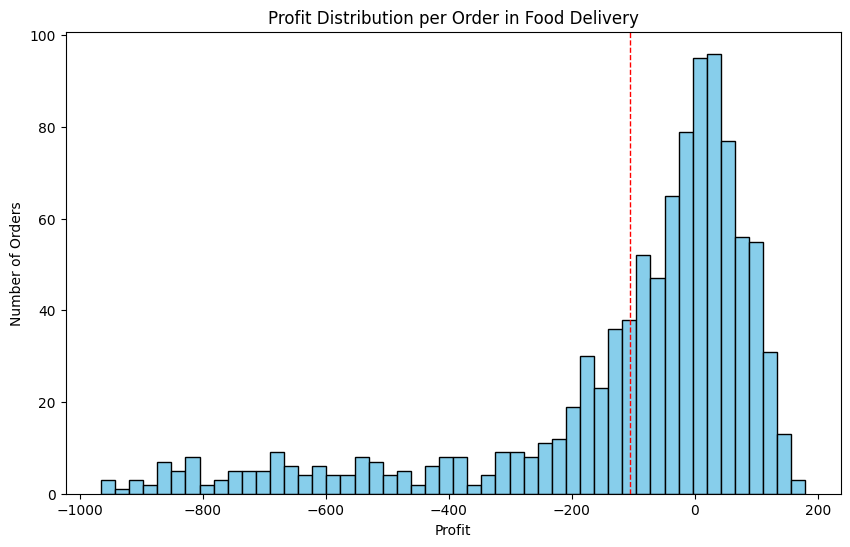

In [8]:
import matplotlib.pyplot as plt

# histogram of profits per order
plt.figure(figsize=(10, 6))
plt.hist(food_orders['Profit'], bins=50, color='skyblue', edgecolor='black')
plt.title('Profit Distribution per Order in Food Delivery')
plt.xlabel('Profit')
plt.ylabel('Number of Orders')
plt.axvline(food_orders['Profit'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.show()

The histogram shows a wide distribution of profit per order, with a noticeable number of orders resulting in a loss (profits below 0). The red dashed line indicates the average profit, which is in the negative territory, highlighting the overall loss-making situation.

Now, let’s have a look at the proportion of total costs:

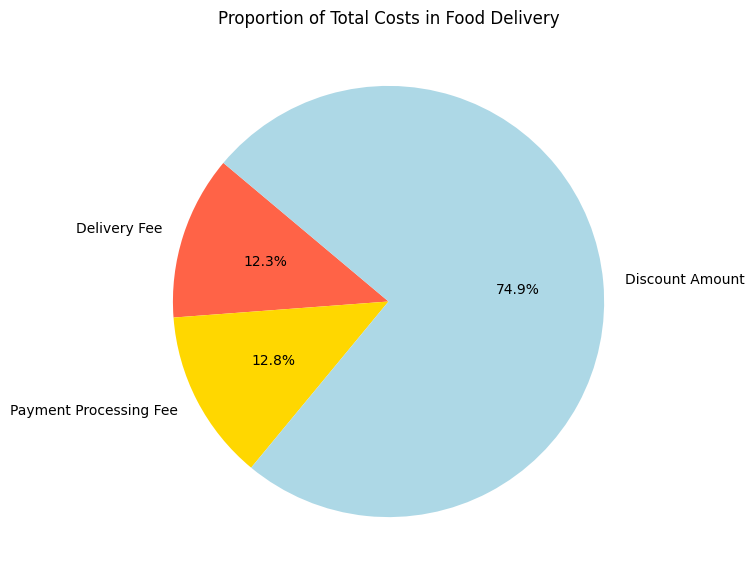

In [9]:
# pie chart for the proportion of total costs
costs_breakdown = food_orders[['Delivery Fee', 'Payment Processing Fee', 'Discount Amount']].sum()
plt.figure(figsize=(7, 7))
plt.pie(costs_breakdown, labels=costs_breakdown.index, autopct='%1.1f%%', startangle=140, colors=['tomato', 'gold', 'lightblue'])
plt.title('Proportion of Total Costs in Food Delivery')
plt.show()

Now, let’s compare total revenue, total costs, and total profit (net loss in our case):

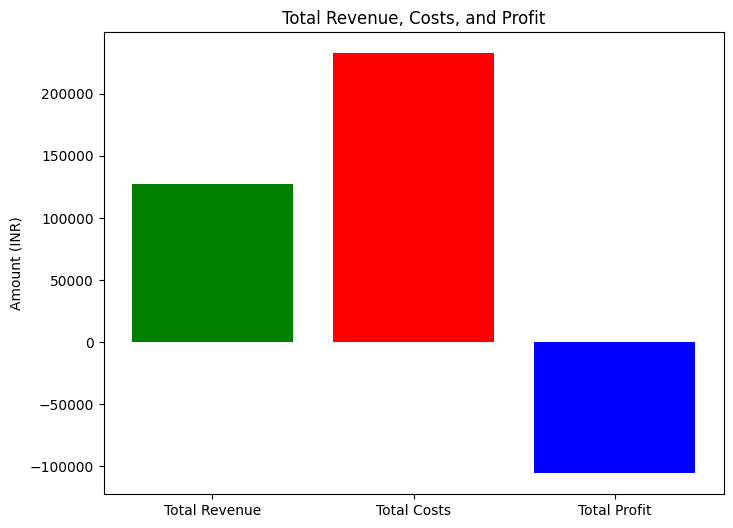

In [10]:
# bar chart for total revenue, costs, and profit
totals = ['Total Revenue', 'Total Costs', 'Total Profit']
values = [total_revenue, total_costs, total_profit]

plt.figure(figsize=(8, 6))
plt.bar(totals, values, color=['green', 'red', 'blue'])
plt.title('Total Revenue, Costs, and Profit')
plt.ylabel('Amount (INR)')
plt.show()

The bar chart compares total revenue, total costs, and total profit. It visually represents the gap between revenue and costs, clearly showing that the costs surpass the revenue, leading to a total loss.

#A New Strategy for Profits

From the analysis so far we understood that the discounts on food orders are resulting in huge losses. Now, we need to find a new strategy for profitability. We need to find a sweet spot for offering discounts and charging commissions. To find a sweet spot for commission and discount percentages, we can analyze the characteristics of profitable orders more deeply. Specifically, we need to look for:

In [12]:
# Filter the dataset for profitable orders
profitable_orders = food_orders[food_orders['Profit'] > 0].copy()  # Create a copy to avoid the warning

# Calculate the average commission percentage for profitable orders
profitable_orders.loc[:, 'Commission Percentage'] = (profitable_orders['Commission Fee'] / profitable_orders['Order Value']) * 100

# Calculate the average discount percentage for profitable orders
profitable_orders.loc[:, 'Effective Discount Percentage'] = (profitable_orders['Discount Amount'] / profitable_orders['Order Value']) * 100

# Calculate the new averages
new_avg_commission_percentage = profitable_orders['Commission Percentage'].mean()
new_avg_discount_percentage = profitable_orders['Effective Discount Percentage'].mean()

print(new_avg_commission_percentage, new_avg_discount_percentage)


30.508436145149435 5.867469879518072


The average commission percentage for profitable orders is significantly higher than the overall average across all orders. It suggests that a higher commission rate on orders might be a key factor in achieving profitability. The average discount percentage for profitable orders is notably lower than the overall average, indicating that lower discounts might contribute to profitability without significantly deterring order volume.

Based on this analysis, a strategy that aims for a commission rate closer to 30% and a discount rate around 6% could potentially improve profitability across the board.

Now, let’s visualize a comparison of profitability using actual versus recommended discounts and commissions across all orders.

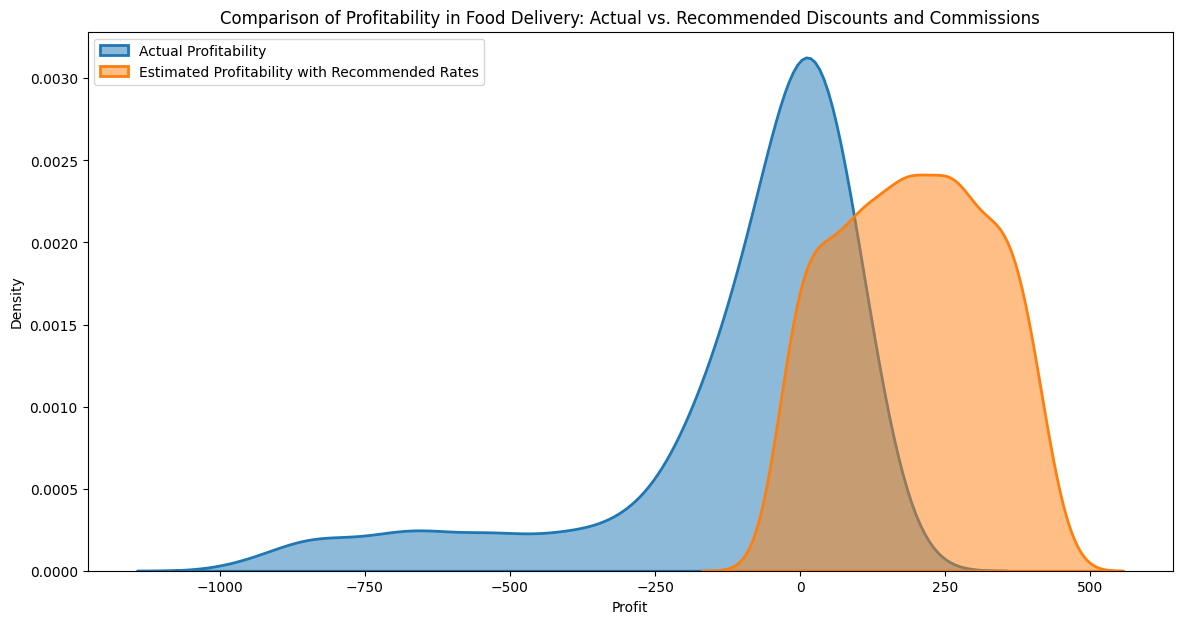

In [13]:
# simulate profitability with recommended discounts and commissions
recommended_commission_percentage = 30.0  # 30%
recommended_discount_percentage = 6.0    # 6%

# calculate the simulated commission fee and discount amount using recommended percentages
food_orders['Simulated Commission Fee'] = food_orders['Order Value'] * (recommended_commission_percentage / 100)
food_orders['Simulated Discount Amount'] = food_orders['Order Value'] * (recommended_discount_percentage / 100)

# recalculate total costs and profit with simulated values
food_orders['Simulated Total Costs'] = (food_orders['Delivery Fee'] +
                                        food_orders['Payment Processing Fee'] +
                                        food_orders['Simulated Discount Amount'])

food_orders['Simulated Profit'] = (food_orders['Simulated Commission Fee'] -
                                   food_orders['Simulated Total Costs'])

# visualizing the comparison
import seaborn as sns

plt.figure(figsize=(14, 7))

# actual profitability
sns.kdeplot(food_orders['Profit'], label='Actual Profitability', fill=True, alpha=0.5, linewidth=2)

# simulated profitability
sns.kdeplot(food_orders['Simulated Profit'], label='Estimated Profitability with Recommended Rates', fill=True, alpha=0.5, linewidth=2)

plt.title('Comparison of Profitability in Food Delivery: Actual vs. Recommended Discounts and Commissions')
plt.xlabel('Profit')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.show()

The visualization compares the distribution of profitability per order using actual discounts and commissions versus the simulated scenario with recommended discounts (6%) and commissions (30%).

The actual profitability distribution shows a mix, with a significant portion of orders resulting in losses (profit < 0) and a broad spread of profit levels for orders. The simulated scenario suggests a shift towards higher profitability per order. The distribution is more skewed towards positive profit, indicating that the recommended adjustments could lead to a higher proportion of profitable orders.

#Summary

So, this is how you can analyze the cost and profitability of a food delivery company. Food Delivery Cost and Profitability Analysis involves examining all the costs associated with delivering food orders, from direct expenses like delivery fees and packaging to indirect expenses like discounts offered to customers and commission fees paid by restaurants. By juxtaposing these costs against the revenue generated (primarily through order values and commission fees), the analysis aims to provide insights into how profitable the food delivery service is on a per-order basis.